In [1]:
from IPython.utils import io

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from scipy.io.arff import loadarff 

from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB, MultinomialNB
from sklearn.svm import SVC
from sklearn.preprocessing import label_binarize
from sklearn.model_selection import(
    train_test_split, 
    KFold,
    GridSearchCV,
)

import tensorflow as tf
from keras.utils import to_categorical
from keras.optimizers import SGD, Adam, Adamax
from keras.wrappers.scikit_learn import KerasClassifier

#utils
from utils.mlp import MLP                           # MLP implementado no Keras para utilização da GPU
from utils.metrics import Metrics, Results          # Funções auxiliares para computar, plotar e salvar métricas

import warnings
warnings.filterwarnings('ignore')

Limitando o uso de VRAM

In [2]:
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)

    except RuntimeError as e:
        print(e)

2022-09-02 14:38:12.860833: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-09-02 14:38:12.960122: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-09-02 14:38:12.960280: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero


## Definição de funções auxiliares

### Para K-Fold CV e GridSearch

In [3]:
def kfold_grid(kf, grid, X, y):
      accuracies_list = list()
      f1_list = list()
      conf_matrix_list = list()
      roc_list = list()
      grid_results = list()

      for fold, (train, test) in enumerate(kf.split(X, y)):
            X_train, X_test = X.iloc[train], X.iloc[test]
            y_train, y_test = y.iloc[train], y.iloc[test]

            if type(grid.estimator).__name__ == 'KerasClassifier':
                  y_train = to_categorical(y_train, num_classes=10)
            else:
                  y_train = y_train.values.ravel()

            with io.capture_output() as captured:
                  grid.fit(X_train, y_train)
                  y_pred = grid.predict(X_test)
                  y_score = grid.predict_proba(X_test)

            accuracy, f1, conf_matrix, roc = Metrics(y_test,y_pred, y_score).compute()
            
            print(f"Fold {fold}\t Accuracy: {accuracy:.3f}")
            print(F"Model best params: {grid.best_params_}")

            accuracies_list.append(accuracy)
            f1_list.append(f1)
            conf_matrix_list.append(conf_matrix)
            roc_list.append(roc)
            grid_results.append(grid.cv_results_)

      return accuracies_list, f1_list, conf_matrix_list, roc_list, grid_results


def grid_Search(kf, model, params, X, y, n_jobs=None):
      grid = GridSearchCV(estimator=model, param_grid=params,
                          scoring='accuracy', n_jobs=n_jobs, 
                          cv=5, refit=True)

      return kfold_grid(kf, grid, X, y)

### Visualização de instâncias do DS

In [4]:
# plot multiple numbers

def plot_images(images):
    n_images = len(images)

    rows = int(np.sqrt(n_images))
    cols = int(np.sqrt(n_images))

    fig = plt.figure()
    for i in range(rows*cols):
        ax = fig.add_subplot(rows, cols, i+1)
        ax.imshow(images[i], cmap='gray_r')
        ax.axis('off')
    
    fig.suptitle('Representação de números aleatórios do dataset')

# DataSet

### Carregando o DataSet

In [5]:
# loading data
raw_data = loadarff('mnist_784.arff')
mnist = pd.DataFrame(raw_data[0])

Devido à limitações de hardware, tomaremos uma amostra estratificada de tamanho n = 5000

In [6]:
df = mnist.groupby('class', group_keys=False).apply(
    lambda x: x.sample(500, random_state=1, ignore_index=True)
    ).sample(frac=1, ignore_index=True, random_state=1)

df.describe()

,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,pixel10,...,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
count,5000.0,5000.0,5000.0,5000.0,5000.0,5000.0,5000.0,5000.0,5000.0,5000.0,...,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.0,5000.0,5000.0,5000.0
mean,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.093400,0.254400,0.145200,0.044000,0.053200,0.012400,0.0,0.0,0.0,0.0
std,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,3.179984,7.708772,4.904093,2.575848,3.464617,0.876812,0.0,0.0,0.0,0.0
min,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0
25%,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0
50%,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0
75%,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0
max,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,156.000000,253.000000,252.000000,177.000000,244.000000,62.000000,0.0,0.0,0.0,0.0


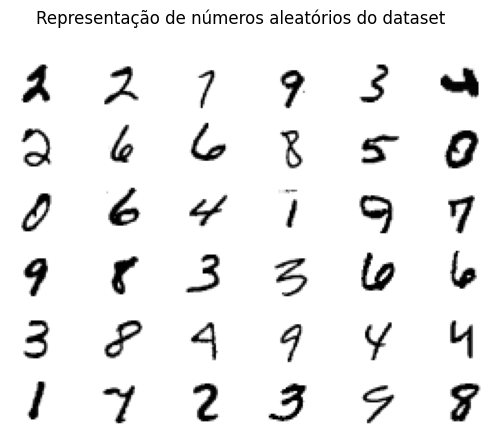

In [7]:
# Visualizando algumas instância do dataset
nums = df['class'].unique()

imgs = list()
for i in np.random.randint(100, size=36):
    rnd_choice = np.random.choice(nums)
    img = pd.array(df[df['class'] == rnd_choice].iloc[i][:-1],
                 dtype=int).reshape((28,28))
    imgs.append(img)

plot_images(imgs)


#### Separando os dados de treino e teste

In [8]:
# treino e teste
X = df.iloc[:, 0:-1]
y = df.iloc[:, [-1]].astype('int') # target

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.1, shuffle=True)

kf = KFold(n_splits=10, shuffle=True)

# Experimentos

### Decision Tree

Fold 0	 Accuracy: 0.738
Model best params: {'criterion': 'entropy', 'max_depth': 50, 'max_features': 100, 'min_samples_split': 10}
Fold 1	 Accuracy: 0.780
Model best params: {'criterion': 'entropy', 'max_depth': 50, 'max_features': 100, 'min_samples_split': 5}
Fold 2	 Accuracy: 0.722
Model best params: {'criterion': 'gini', 'max_depth': 50, 'max_features': 100, 'min_samples_split': 5}
Fold 3	 Accuracy: 0.764
Model best params: {'criterion': 'entropy', 'max_depth': 50, 'max_features': 100, 'min_samples_split': 5}
Fold 4	 Accuracy: 0.709
Model best params: {'criterion': 'entropy', 'max_depth': 50, 'max_features': 100, 'min_samples_split': 5}
Fold 5	 Accuracy: 0.764
Model best params: {'criterion': 'entropy', 'max_depth': 50, 'max_features': 100, 'min_samples_split': 10}
Fold 6	 Accuracy: 0.778
Model best params: {'criterion': 'entropy', 'max_depth': 50, 'max_features': 100, 'min_samples_split': 10}
Fold 7	 Accuracy: 0.711
Model best params: {'criterion': 'entropy', 'max_depth': 50, 'max_

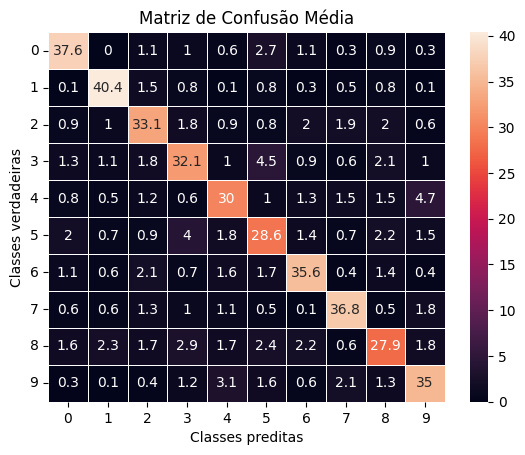

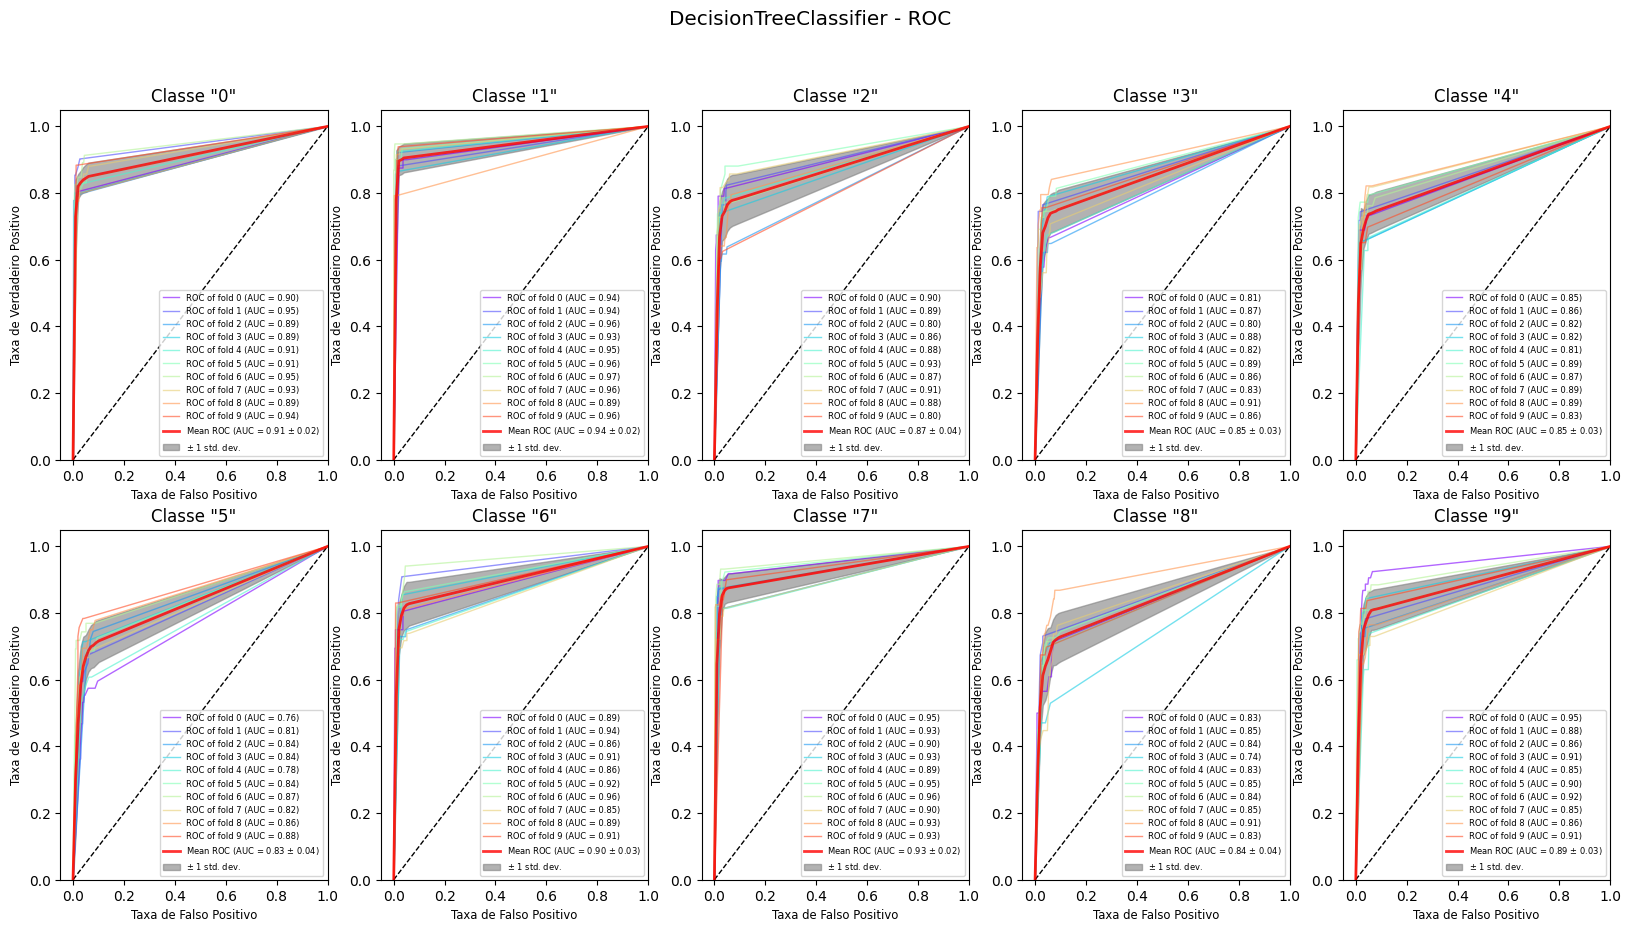

In [11]:
DT = DecisionTreeClassifier(random_state=0)
dt_params = {
    'criterion': ['gini', 'entropy'],
    'max_depth':[5, 50, 100],
    'min_samples_split': [5, 10, 30],
    'max_features':[10, 30, 100, 'sqrt'],
}
dt_acc, dt_f1, dt_cm, dt_roc, dt_grid_results = grid_Search(kf, DT, dt_params, X_train, y_train, n_jobs=-1)

print("\n-----------------------------------------------------\n")
dt_results = Results(type(DT).__name__, dt_acc, dt_f1,
                           dt_cm, dt_roc, dt_grid_results)
dt_results.save()
dt_results.plot()


### Naive Bayes

#### Gaussian NB

Fold 0	 Accuracy: 0.831
Model best params: {'var_smoothing': 0.1}
Fold 1	 Accuracy: 0.842
Model best params: {'var_smoothing': 0.1}
Fold 2	 Accuracy: 0.802
Model best params: {'var_smoothing': 0.1}
Fold 3	 Accuracy: 0.818
Model best params: {'var_smoothing': 0.1}
Fold 4	 Accuracy: 0.827
Model best params: {'var_smoothing': 0.1}
Fold 5	 Accuracy: 0.767
Model best params: {'var_smoothing': 0.1}
Fold 6	 Accuracy: 0.802
Model best params: {'var_smoothing': 0.1}
Fold 7	 Accuracy: 0.831
Model best params: {'var_smoothing': 0.1}
Fold 8	 Accuracy: 0.787
Model best params: {'var_smoothing': 0.1}
Fold 9	 Accuracy: 0.804
Model best params: {'var_smoothing': 0.1}

-----------------------------------------------------



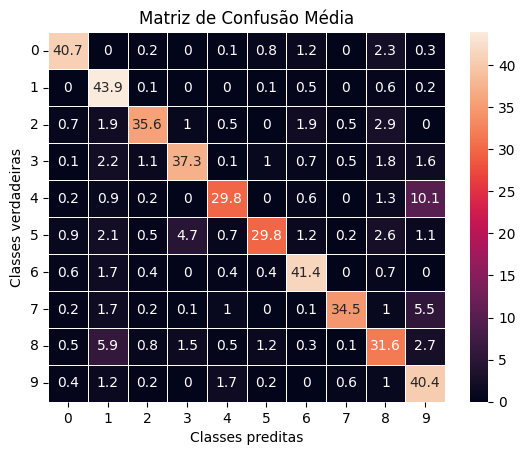

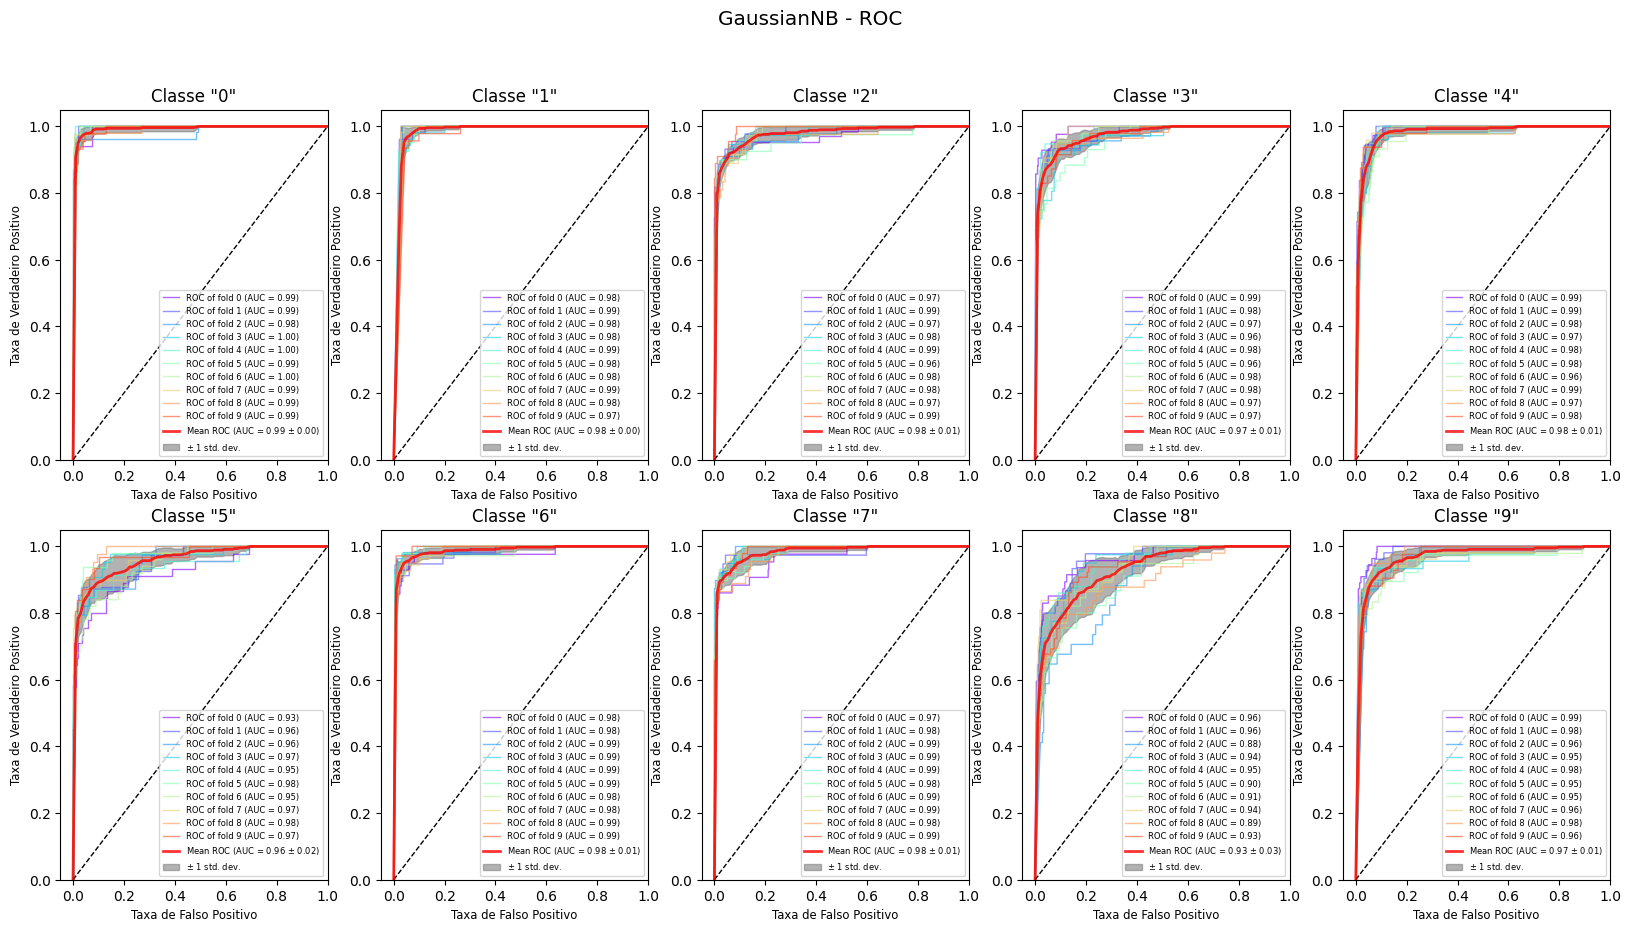

In [12]:
gnb = GaussianNB()
gnb_params = {
    'var_smoothing': np.logspace(0,-9, num=10)
}

gnb_acc, gnb_f1, gnb_cm, gnb_roc, gnb_grid_results = grid_Search(kf, gnb, gnb_params,
                                               X_train, y_train, n_jobs=-1)

print("\n-----------------------------------------------------\n")
gnb_results = Results(type(gnb).__name__, gnb_acc, gnb_f1,
                           gnb_cm, gnb_roc, gnb_grid_results)
gnb_results.save()
gnb_results.plot()


#### Multinomial NB

Fold 0	 Accuracy: 0.829
Model best params: {'alpha': 0.001}
Fold 1	 Accuracy: 0.811
Model best params: {'alpha': 1e-06}
Fold 2	 Accuracy: 0.853
Model best params: {'alpha': 1e-05}
Fold 3	 Accuracy: 0.853
Model best params: {'alpha': 1e-06}
Fold 4	 Accuracy: 0.858
Model best params: {'alpha': 0.1}
Fold 5	 Accuracy: 0.804
Model best params: {'alpha': 1e-05}
Fold 6	 Accuracy: 0.816
Model best params: {'alpha': 0.01}
Fold 7	 Accuracy: 0.840
Model best params: {'alpha': 1e-07}
Fold 8	 Accuracy: 0.840
Model best params: {'alpha': 0.001}
Fold 9	 Accuracy: 0.844
Model best params: {'alpha': 0.1}

-----------------------------------------------------



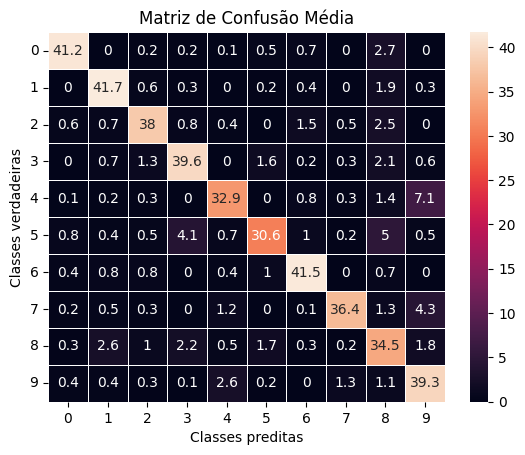

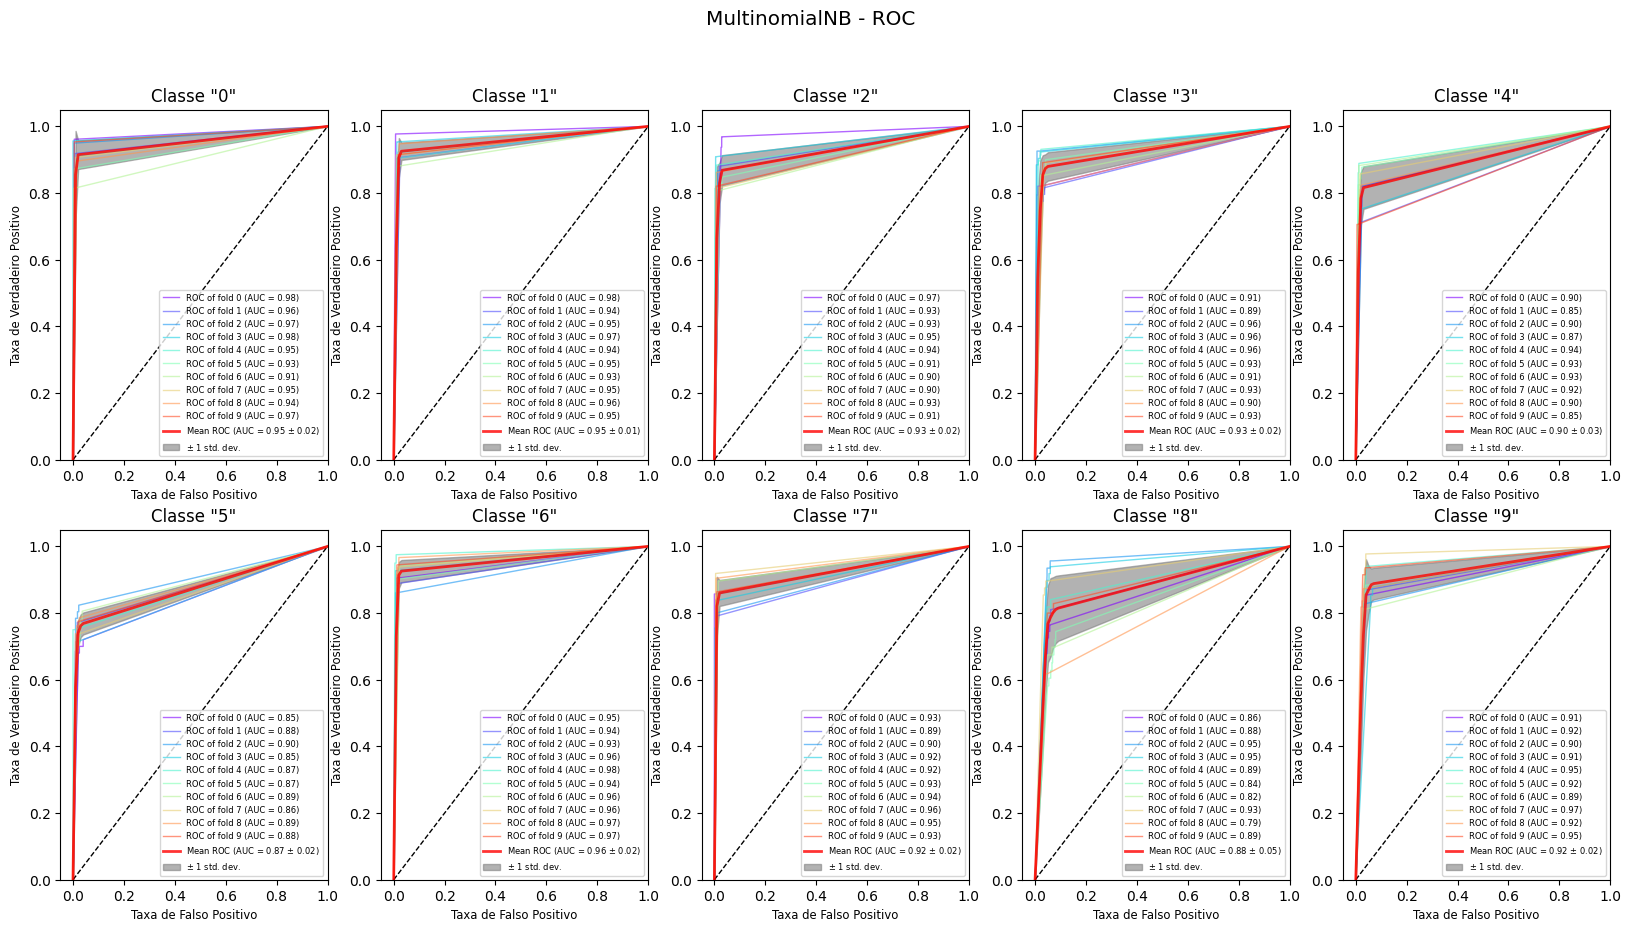

In [13]:
mnnb = MultinomialNB()
mnnb_params = {
    'alpha': np.logspace(0,-9, num=10)
}

mnnb_acc, mnnb_f1, mnnb_cm, mnnb_roc, mnnb_grid_results = grid_Search(kf, mnnb, mnnb_params,
                                                   X_train, y_train, n_jobs=-1)


print("\n-----------------------------------------------------\n")
mnnb_results = Results(type(mnnb).__name__, mnnb_acc, mnnb_f1, 
                           mnnb_cm, mnnb_roc, mnnb_grid_results)
mnnb_results.save()
mnnb_results.plot()

### KNN

Fold 0	 Accuracy: 0.922
Model best params: {'metric': 'euclidean', 'n_neighbors': 3}
Fold 1	 Accuracy: 0.920
Model best params: {'metric': 'euclidean', 'n_neighbors': 3}
Fold 2	 Accuracy: 0.933
Model best params: {'metric': 'euclidean', 'n_neighbors': 3}
Fold 3	 Accuracy: 0.938
Model best params: {'metric': 'euclidean', 'n_neighbors': 3}
Fold 4	 Accuracy: 0.920
Model best params: {'metric': 'euclidean', 'n_neighbors': 5}
Fold 5	 Accuracy: 0.933
Model best params: {'metric': 'euclidean', 'n_neighbors': 3}
Fold 6	 Accuracy: 0.949
Model best params: {'metric': 'euclidean', 'n_neighbors': 3}
Fold 7	 Accuracy: 0.911
Model best params: {'metric': 'euclidean', 'n_neighbors': 3}
Fold 8	 Accuracy: 0.900
Model best params: {'metric': 'euclidean', 'n_neighbors': 7}
Fold 9	 Accuracy: 0.918
Model best params: {'metric': 'euclidean', 'n_neighbors': 3}

-----------------------------------------------------



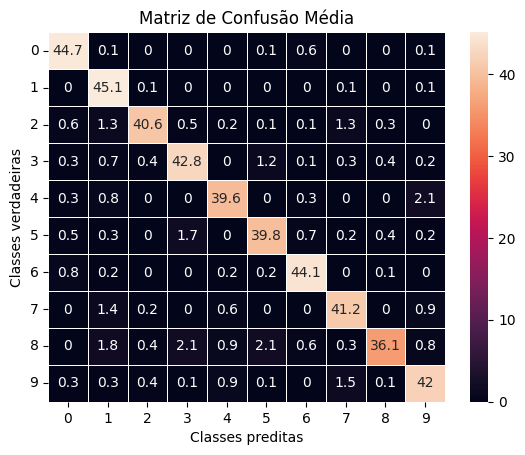

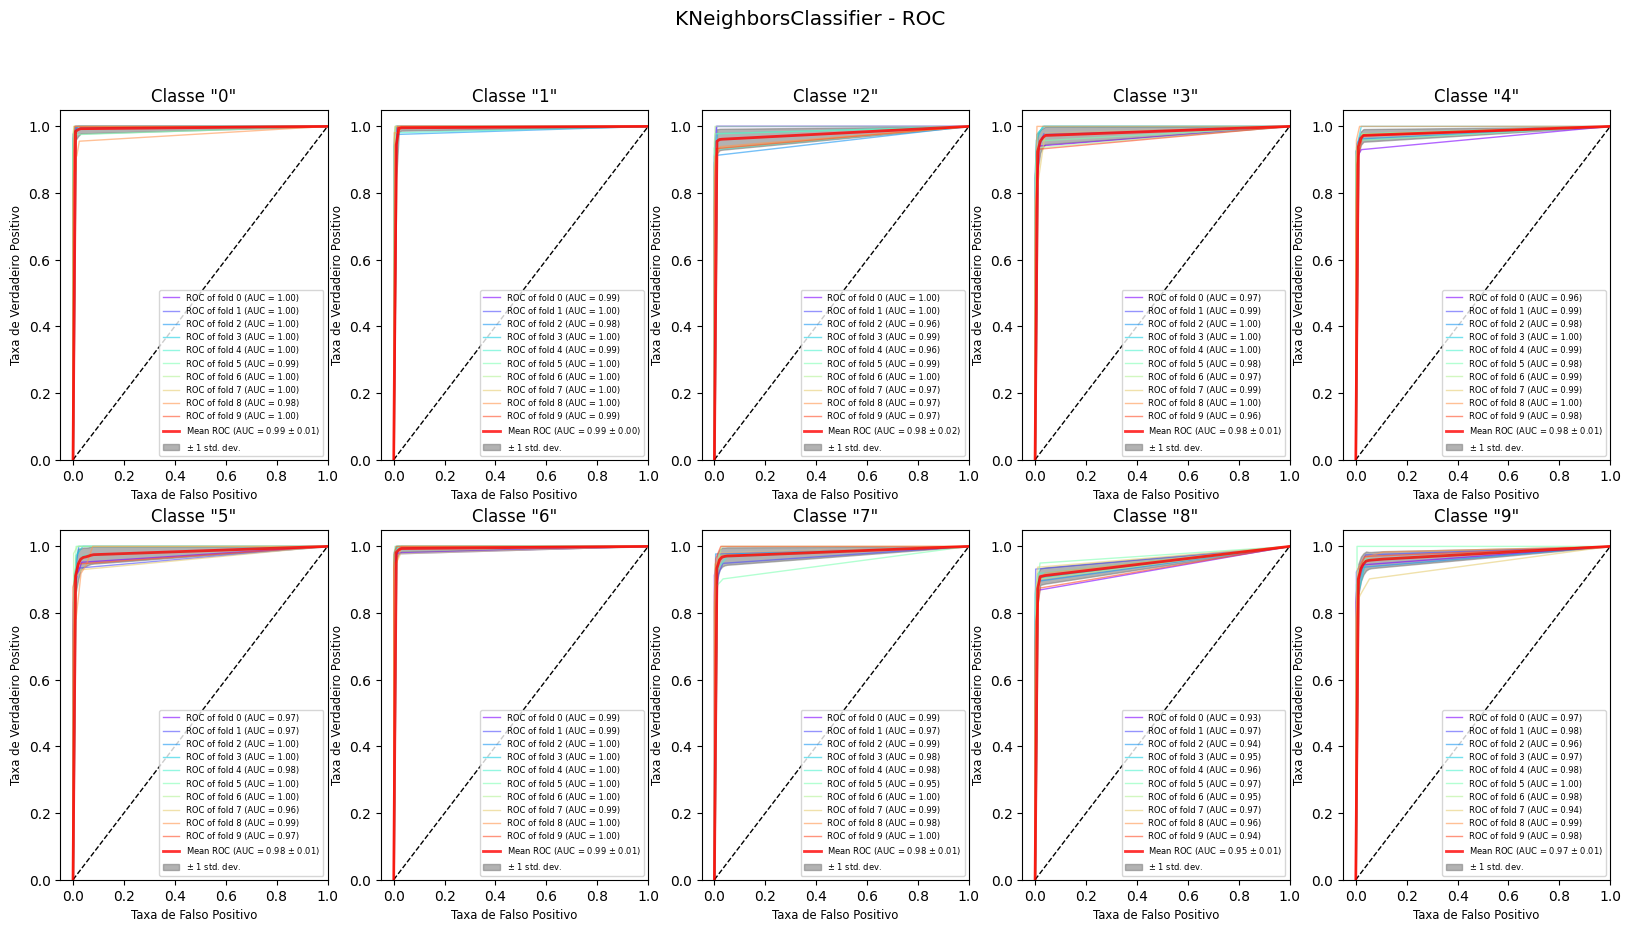

In [14]:
knn = KNeighborsClassifier(n_jobs=-1)
knn_params = {'n_neighbors': [3, 5, 7],
             'metric': ['euclidean', 'manhattan']}

knn_acc, knn_f1, knn_cm, knn_roc, knn_grid_results = grid_Search(kf, knn, knn_params, X_train, y_train, n_jobs=-1)

print("\n-----------------------------------------------------\n")
knn_results = Results(type(knn).__name__, knn_acc, knn_f1, 
                           knn_cm, knn_roc, knn_grid_results)
knn_results.save()
knn_results.plot()

### SVC

Fold 0	 Accuracy: 0.956
Model best params: {'C': 10000.0, 'degree': 2, 'kernel': 'poly'}
Fold 1	 Accuracy: 0.944
Model best params: {'C': 10000.0, 'degree': 2, 'kernel': 'poly'}
Fold 2	 Accuracy: 0.929
Model best params: {'C': 10.0, 'degree': 2, 'kernel': 'poly'}
Fold 3	 Accuracy: 0.940
Model best params: {'C': 10.0, 'degree': 2, 'kernel': 'poly'}
Fold 4	 Accuracy: 0.931
Model best params: {'C': 10000.0, 'degree': 2, 'kernel': 'poly'}
Fold 5	 Accuracy: 0.956
Model best params: {'C': 10.0, 'degree': 2, 'kernel': 'poly'}
Fold 6	 Accuracy: 0.936
Model best params: {'C': 10000.0, 'degree': 2, 'kernel': 'poly'}
Fold 7	 Accuracy: 0.956
Model best params: {'C': 10000.0, 'degree': 2, 'kernel': 'poly'}
Fold 8	 Accuracy: 0.958
Model best params: {'C': 10.0, 'degree': 2, 'kernel': 'poly'}
Fold 9	 Accuracy: 0.953
Model best params: {'C': 10000.0, 'degree': 2, 'kernel': 'poly'}

-----------------------------------------------------



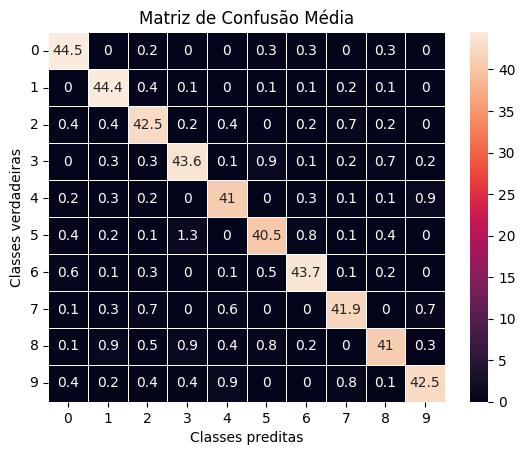

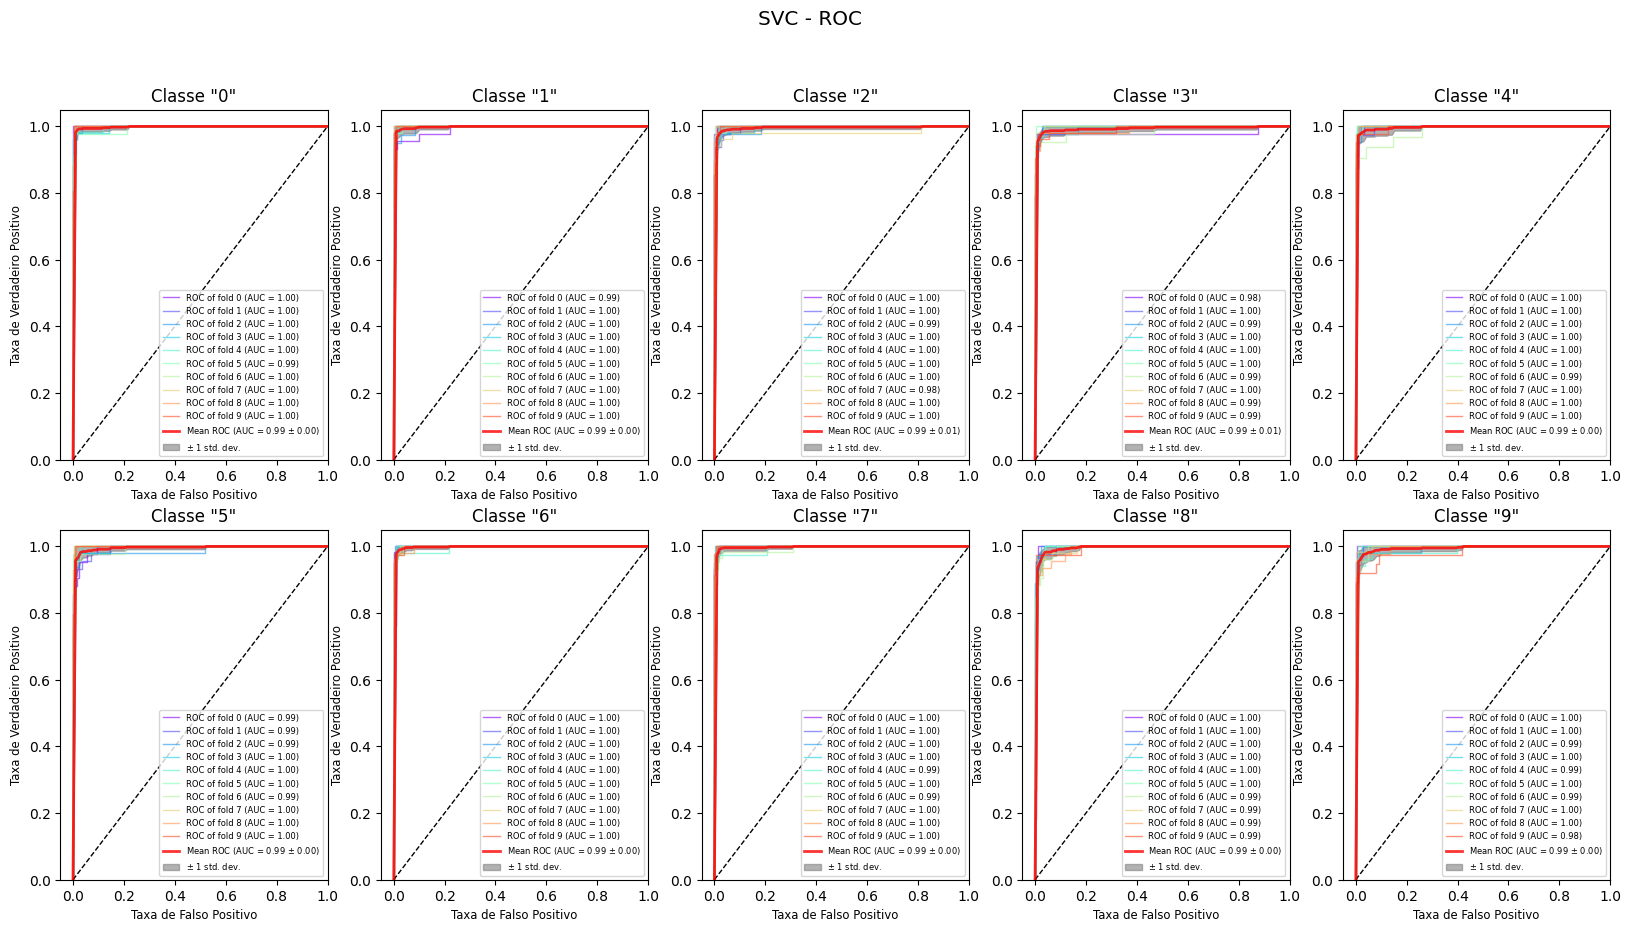

In [15]:
svc = SVC(probability=True)

svc_params = [
    {'C': np.logspace(4,-1, num=6),
     'kernel':['linear']},
    
    {'C': np.logspace(4,-1, num=6),
     'kernel': ['poly'],
     'degree': [2, 3]},
]

svc_acc, svc_f1, svc_cm, svc_roc, svc_grid_results = grid_Search(kf, svc, svc_params,
                                               X_train, y_train, n_jobs=-1)

print("\n-----------------------------------------------------\n")
svc_results = Results(type(svc).__name__, svc_acc, svc_f1, 
                           svc_cm, svc_roc, svc_grid_results)
svc_results.save()
svc_results.plot()


### MLP

In [ ]:
mlp = KerasClassifier(build_fn=MLP, n_classes=10, input_shape=(28*28,), verbose=0)

mlp_params = {
    'epochs': [20, 30, 50],
    'batch_size':[128, 256],
    'n_neurons':[[500]*2, [1000]*2, [500]*3, [1000]*3],
    'optimizer': [Adam, Adamax, SGD],
    'lr': [0.001, 0.002, 0.003]
}


mlp_acc, mlp_f1, mlp_cm, mlp_roc, mlp_grid_results = grid_Search(kf, mlp, mlp_params, X_train, y_train)

print("\n-----------------------------------------------------\n")
mlp_results = Results('MLP', mlp_acc, mlp_f1, 
                           mlp_cm, mlp_roc, mlp_grid_results)
mlp_results.save()
mlp_results.plot()


### Treinando o SVC como modelo final

In [13]:
svc = SVC(probability=True)

svc_params = [
    {'C': np.logspace(4,-1, num=6),
     'kernel':['linear']},
    
    {'C': np.logspace(4,-1, num=6),
     'kernel': ['poly'],
     'degree': [2, 3]},
]
grid = GridSearchCV(estimator=svc, param_grid=svc_params,
                          scoring='accuracy', n_jobs=-1, 
                          cv=5, refit=True)

grid.fit(X_train ,y_train.values.ravel())

GridSearchCV(cv=5, estimator=SVC(probability=True), n_jobs=-1,
             param_grid=[{'C': array([1.e+04, 1.e+03, 1.e+02, 1.e+01, 1.e+00, 1.e-01]),
                          'kernel': ['linear']},
                         {'C': array([1.e+04, 1.e+03, 1.e+02, 1.e+01, 1.e+00, 1.e-01]),
                          'degree': [2, 3], 'kernel': ['poly']}],
             scoring='accuracy')

In [26]:
best_model = SVC(**grid.best_params_, probability=True)

best_model.fit(X_train, y_train.values.ravel())

SVC(C=10000.0, degree=2, kernel='poly', probability=True)

In [36]:
from sklearn.metrics import classification_report
y_pred = best_model.predict(X_val)
y_score = best_model.predict_proba(X_val)

print(classification_report(y_val, y_pred, digits=3))


              precision    recall  f1-score   support

           0      0.931     0.964     0.947        56
           1      0.909     1.000     0.952        40
           2      0.964     0.931     0.947        58
           3      0.945     0.912     0.929        57
           4      0.941     1.000     0.970        48
           5      0.935     0.935     0.935        46
           6      0.978     0.978     0.978        46
           7      0.947     0.964     0.956        56
           8      0.947     0.900     0.923        40
           9      0.980     0.906     0.941        53

    accuracy                          0.948       500
   macro avg      0.948     0.949     0.948       500
weighted avg      0.949     0.948     0.948       500

